# **Import modules**

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import time
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt

import umap
from torch.utils.data import WeightedRandomSampler
import random
import numpy as np
from google.colab import drive

from fastai.callbacks import *
from fastai.text import *
from fastai.metrics import *

from sklearn.model_selection import StratifiedShuffleSplit,train_test_split
from sklearn.metrics import roc_auc_score, recall_score, precision_score,balanced_accuracy_score,average_precision_score,confusion_matrix,plot_confusion_matrix, plot_precision_recall_curve,recall_score, precision_score, matthews_corrcoef, make_scorer, precision_recall_curve

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from rdkit import Chem
from rdkit import rdBase
from rdkit.Chem import Draw, AllChem
from IPython.display import display,Image, SVG
from rdkit.Chem import rdmolops
rdBase.DisableLog('rdApp.error')

# **Define paths**

In [ ]:
COV = Path('generative_model')
COV.mkdir(parents=True, exist_ok=True)

In [ ]:
COVCLS = Path('classifier/')
COVCLS.mkdir(parents=True, exist_ok=True)

# **Helper functions**

**Sampling callback**

In [ ]:
def is_valid(smiles):
  mol = Chem.MolFromSmiles(smiles)
  if mol is not None and mol.GetNumAtoms()>0:
    return smiles

def uniqueness_score(mols): return set(mols)

def novelty_score(mols,ref_mols): return set.difference(mols,ref_mols)

class SamplingCB(LearnerCallback):

  '''Sampling callback to generate molecules at the end of each training epoch and compute validity,
  novelty and uniqueness.
  learn: Learner

  source_mols: List -> Reference molecules to compute dataset. 

  objective_mols: List -> If finetuning is True, the objective is the dataset we are finetuning to.

  num_samples: Int -> Number of molecules to generate
  '''
  _order=-20 # Needs to run before the recorder
  def __init__(self,learn:Learner,objective_mols:Collection=None,num_samples:int=100):
    super().__init__(learn)
    self.num_samples= num_samples
    self.max_size = 120
    self.temperature = 0.7
    self.objective_mols = objective_mols

  def on_train_begin(self,**kwargs):
    self.ref_model = load_ref_model()
    self.learn.recorder.add_metric_names(['Valid', 'Unique', 'Novel'])

  def on_epoch_being(self,**kwargs):
    self.objective_mols = random.sample(objective_mols,self.num_samples)

  def sampling(self,text:str='', sep:str=''):
    "Vanilla sampling. Return `text` and the `n_words` that come after"
    m = self.learn
    m.model.reset()
    v = self.learn.data.train_ds.vocab
    v_sz = len(v.itos)
   # print(v.itos[v_sz-1])
    xb,yb = self.learn.data.one_item(text)
    new_idx = []
    for _ in range(self.max_size):
      res = m.pred_batch(batch=(xb,yb))[0][-1]
      if self.temperature != 1.: 
        res.pow_(1 / self.temperature)
      idx = torch.multinomial(res, 1).item()
      if idx != v_sz-1:              
        new_idx.append(idx)
        xb = xb.new_tensor([idx])[None]
      else:
        break
    return text + sep + sep.join(v.textify(new_idx, sep=None))

  def on_epoch_end(self, last_metrics, **kwargs):
    print('Sampling...')
    p = [self.sampling().replace('xxbos','').replace('xxeos','').replace('xxunk','').replace('xxpad','') for i in range(0,self.num_samples)]
    print('Sample of generated SMILES')
    print(p[:5])

    val = list(filter(is_valid,p)) # Validity
    print(val[0:5])
    uniq = uniqueness_score(val) # Uniqueness
    novel = novelty_score(uniq, self.objective_mols) # Novelty

    return add_metrics(last_metrics, [len(val)/self.num_samples, len(uniq)/self.num_samples, len(novel)/self.num_samples])


**Precision-recall curve metric**

In [ ]:
class AUCPR(Callback):
    "Computes the area under the curve (AUC) score based on Precision-Recall curve."
    def on_epoch_begin(self, **kwargs):
        self.targs, self.preds = LongTensor([]), Tensor([])
        
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        last_output = F.softmax(last_output, dim=1)[:,0]
        self.preds = torch.cat((self.preds, last_output.cpu()))
        #print(self.preds[:10])
        self.targs = torch.cat((self.targs, last_target.cpu().long()))
    
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, average_precision_score(self.targs,self.preds,pos_label=0))
        
def is_valid(smiles):
  mol = Chem.MolFromSmiles(smiles)
  if mol is not None and mol.GetNumAtoms()>0:
    return smiles

def uniqueness_score(mols): return set(mols)

def novelty_score(mols,ref_mols): return set.difference(mols,ref_mols)

def sampling(model,dt,text:str, n_words:int, temperature:float=1., sep:str=' '):
  "Vanilla sampling. Return `text` and the `n_words` that come after"
  model.model.reset()
  v = dt.vocab
  
  xb,yb = dt.one_item(text)
  new_idx = []
  for _ in range(n_words):
    res = model.pred_batch(batch=(xb,yb))[0][-1]

    if temperature != 1.: 
      res.pow_(1 / temperature)
    idx = torch.multinomial(res, 1).item()
    if idx != len(v.itos)-1:              
      new_idx.append(idx)
      xb = xb.new_tensor([idx])[None]
    else:
      break
  return text + sep + sep.join(v.textify(new_idx, sep=None))
sampling_temperatures = [0.2,0.5,0.6,0.7,0.75,0.8,1.0,1.2]
def validation(model,dt,sampling_temperatures,iterations,samples,ref,maxsize=140):
  
  '''Vanilla sampling and validation function'''
  _validity = np.zeros((iterations,len(sampling_temperatures)))
  _novelty = np.zeros((iterations,len(sampling_temperatures)))
  _uniqueness = np.zeros((iterations,len(sampling_temperatures)))

  for j in range(len(sampling_temperatures)):
    temp = sampling_temperatures[j]
    print('Temperatures = {}'.format(temp))
    for i in range(iterations):
      print('Starting iteration {}'.format(i))
      p = [sampling(model,dt,text='',n_words=maxsize,sep='',temperature=temp).replace(PAD,'').replace(BOS,'').replace(EOS,'').replace(UNK,'') for i in range(0,samples)]
      mols = list(filter(is_valid,p)) # Valid
      unq_mols = uniqueness_score(mols) # Uniqueness # Unique
      novel_mols = novelty_score(unq_mols, ref) # Novel

      _novelty[i,j] = len(novel_mols)/samples*100
      _uniqueness[i,j] = len(unq_mols)/samples*100
      _validity[i,j] = len(mols)/samples*100

      print('Iteration {} ended'.format(i))
    print('----------------------------------')
  return _validity, _novelty, _uniqueness

**Tokenizer**

In [ ]:
#@title
class MolTokenizer(BaseTokenizer):
  ''' Atom-level tokenizer. Splits molecules into individual atoms and special enviroments.
  A special enviroment is defined by any elements inside square brackets (e.g., [nH])
  '''
  def __init__(self, lang:str):
    pass
  def tokenizer(self,t:str) -> List[str]:
    assert type(t) == str
    pat = '(\[.*?\])' # Find special enviroments (e.g., [CH],[NH] etc)
    tokens = []
    t = t.replace('Br','L').replace('Cl','X') # Replace halogens
    atom_list = re.split(pat,t)
    for s in atom_list:
      if s.startswith('['):
        tokens.append(s)
      else:
        tokens += [x for x in list(s)]
    tokens = [x.replace('L','Br').replace('X','Cl') for x in tokens] # Decode halogens
    return [BOS] + tokens + [EOS]# + [PAD for i in range(133-len(tokens))]

class Create_Vocab(object):
  '''Tokenize and create vocabulary of atoms in SMILES strings'''
  def __init__(self,smiles):
    self.smiles = smiles

  def tokenize(self):
    k = MolTokenizer
    tok = Tokenizer(k,pre_rules=[],post_rules=[])
    tokens = tok.process_all(self.smiles)

    unique_tokens = [UNK, PAD] + sorted(list({y for x in tokens for y in x}))
    vocab = Vocab(itos=unique_tokens)
    
    return unique_tokens, vocab



# **Load data**

In [ ]:
chembl = pd.read_csv('data/ChEMBL_v1.csv')

# **General chemical model (Encoder)**

**Tokenize data**

In [ ]:
vocab_list = Create_Vocab(list(chembl.Smiles))
unique_tokens,vocab = vocab_list.tokenize()

**Databunch**

In [ ]:
tokenizer = Tokenizer(MolTokenizer,pre_rules=[],post_rules=[],special_cases=[PAD,BOS,EOS,UNK])
processors = [TokenizeProcessor(tokenizer=tokenizer, mark_fields=False,include_bos=False),
            NumericalizeProcessor(vocab=vocab)]
src = (TextList.from_df(chembl,cols='Smiles',processor=processors).split_by_rand_pct(0.10).label_for_lm())


In [ ]:
data = src.databunch()

In [ ]:
data.show_batch()

idx,text
0,C ( C O P ( = O ) ( O ) O ) O 3 ) c ( = O ) [nH] c 2 = O ) c c 1 xxeos xxbos C O c 1 c ( - c 2 c n [nH] c 2 ) c c c ( C ( = O ) N C ( C O ) c 2 c ( F ) c
1,3 = N O C ( c 4 c c c ( F ) c c 4 ) C 3 ) s c 3 n c c c c 2 3 ) c c 1 xxeos xxbos N S ( = O ) ( = O ) c 1 c c c c c 1 N S ( = O ) ( = O ) c 1 c c c
2,c ( C ) c 1 O xxeos xxbos C O c 1 c c c ( C 2 C N ( C ) C c 3 c c ( O C C C N 4 C C N ( c 5 c c c c c 5 O ) C C 4 ) c c c 3 2 ) c c 1 xxeos xxbos C O C C O
3,C c 3 c c c c c 3 Cl ) S ( C ) ( = O ) = O ) c c 2 ) C C 1 xxeos xxbos C O c 1 c c 2 c ( c ( O C ) c 1 O C ) c 1 c 3 c ( c c 4 c 1 n 2 C ( = O ) C C
4,c c c 1 F xxeos xxbos C N ( C C C C N 1 C ( = O ) c 2 c c c c c 2 C 1 = O ) C c 1 c c c c ( Cl ) c 1 xxeos xxbos C C 1 C N ( C ( C ) C O ) C ( = O ) c 2 c c


In [ ]:
data.save('data_general.pkl')

In [ ]:
#data = load_data(Drive,'data_v2_1.pkl')

In [ ]:
learn = language_model_learner(data, AWD_LSTM, config=config,pretrained=False,drop_mult=0.1,model_dir=Path('.'),
                               metrics=[accuracy,error_rate],callback_fns=[partial(CSVLogger,append=True)])

In [ ]:
data.show_batch(
    
)

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,2 N 2 C C O C C 2 ) c c 1 O C C xxeos xxbos C C C N C ( = O ) c 1 c c c 2 c ( c c n 2 - c 2 n c c 3 c ( n 2 ) N ( C 2 C C C C 2 ) C ( C C ) C ( = O
1,1 C C C ( c 2 n o c 3 c c c ( F ) c c 2 3 ) C C 1 xxeos xxbos O = C ( C C n 1 c ( = O ) o c 2 c c ( Cl ) c c c 2 1 ) N c 1 c c c ( N 2 C C O C C 2 )
2,c c c 5 o 4 ) n n 2 3 ) c 1 xxeos xxbos C ( = N N c 1 n c 2 c c c c c 2 o 1 ) c 1 c c c c n 1 xxeos xxbos O = C ( N c 1 c c c ( C c 2 c c c c c 2 ) c c 1 )
3,( C ) = O ) C 1 2 C xxeos xxbos O = C ( N C c 1 c c c ( C ( = O ) N 2 C C C ( c 3 c c c c c 3 ) C C 2 ) c c 1 ) N c 1 c c c ( Cl ) c c 1 xxeos xxbos C N ( C
4,( F ) ( F ) F ) c 2 ) C C 1 xxeos xxbos O = P 1 ( N ( C C Cl ) C C Cl ) N C C ( Cl ) C O 1 xxeos xxbos C O C ( = O ) C 1 C S C ( c 2 n c 3 c c c ( O C ) c c 3


In [ ]:
learn.load('fit1');

In [ ]:
data = load_data(path=Path('data'),file='data_v2_1.pkl')

In [ ]:
data.vocab.save('data/vocab.pkl')

In [ ]:
learn.lr_find(num_it=600)

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.09E-05
Min loss divided by 10: 2.03E-02


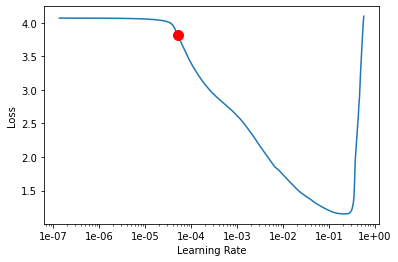

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
config = awd_lstm_lm_config.copy()
config['n_hid'] = 512;

In [ ]:
learn.fit_one_cycle(10, 3e-3,callbacks=[SamplingCB(learn,num_samples=1000,objective_mols=set(list(chembl.Smiles))),
                                        SaveModelCallback(learn, every='improvement', monitor='accuracy', name='bestmodel')])                     

In [ ]:
learn.save('general_weights')

In [ ]:
learn.save_encoder('general_encoder')

In [ ]:
learn.validate(data.valid_dl)

[0.47671342, tensor(0.8304), tensor(0.1696)]

In [ ]:
learn.export(file='general_model.pkl')

## **Validation**

In [ ]:
validity, novelty, uniqueness,mols,unq_mols,novel_mols = validation(learn,data,sampling_temperatures,5,2000,ref=list(df.Smiles))

Temperatures = 0.2
Starting iteration 0
Iteration 0 ended
Starting iteration 1
Iteration 1 ended
Starting iteration 2
Iteration 2 ended
Starting iteration 3
Iteration 3 ended
Starting iteration 4
Iteration 4 ended
----------------------------------
Temperatures = 0.5
Starting iteration 0
Iteration 0 ended
Starting iteration 1
Iteration 1 ended
Starting iteration 2
Iteration 2 ended
Starting iteration 3
Iteration 3 ended
Starting iteration 4
Iteration 4 ended
----------------------------------
Temperatures = 0.6
Starting iteration 0
Iteration 0 ended
Starting iteration 1
Iteration 1 ended
Starting iteration 2
Iteration 2 ended
Starting iteration 3
Iteration 3 ended
Starting iteration 4
Iteration 4 ended
----------------------------------
Temperatures = 0.7
Starting iteration 0
Iteration 0 ended
Starting iteration 1
Iteration 1 ended
Starting iteration 2
Iteration 2 ended
Starting iteration 3
Iteration 3 ended
Starting iteration 4
Iteration 4 ended
----------------------------------
Temp

In [ ]:
val_df = pd.DataFrame(validity,columns=['Temp_{}'.format(i) for i in sampling_temperatures])
nov_df = pd.DataFrame(novelty,columns=['Temp_{}'.format(i) for i in sampling_temperatures])
unq_df = pd.DataFrame(uniqueness,columns=['Temp_{}'.format(i) for i in sampling_temperatures])


In [ ]:
nov_df

,Temp_0.2,Temp_0.5,Temp_0.6,Temp_0.7,Temp_0.75,Temp_0.8,Temp_1.0,Temp_1.2
0,87.530562,81.408597,83.088608,85.642570,88.250126,87.455741,93.089005,96.628571
1,89.588101,81.771370,83.291139,85.341365,87.280040,89.202825,93.937824,96.420455
2,89.195402,82.814123,82.845610,85.728643,87.481146,89.303734,93.840580,96.384840
3,88.782816,81.667530,81.698686,85.699899,87.368421,89.494949,92.559834,96.235026
4,89.868892,80.735370,83.854692,85.879397,87.562941,88.258906,92.920354,96.950875


# **Fine tuning**

In [ ]:
full = pd.read_csv('data/AID_1706_misc_combined_processed',sep=';')

**Tokenize data**

In [ ]:
vocab_list = Create_Vocab(list(full.processed_smiles))
unique_tokens,vocab = vocab_list.tokenize()

**Databunch**

In [ ]:
tokenizer = Tokenizer(MolTokenizer,pre_rules=[],post_rules=[],special_cases=[PAD,BOS,EOS,UNK])
processors = [TokenizeProcessor(tokenizer=tokenizer, mark_fields=False,include_bos=False),
            NumericalizeProcessor(vocab=vocab)]
src = (TextList.from_df(full,path=COV,cols='processed_smiles',processor=processors).split_by_rand_pct(0.10).label_for_lm())

In [ ]:
data_fn = src.databunch()

In [ ]:
data_fn.show_batch()

idx,text
0,N ) c 4 c c c c c 3 4 ) C ( = O ) N C 2 = O ) c 2 c c c c c 2 1 xxeos xxbos C N ( C ) C C C n 1 c c ( C 2 = C ( c 3 c n ( C ) c 4 c c c c c 3 4 ) C
1,n c 3 2 ) c 1 xxeos xxbos C C N ( C C ) c 1 c c c ( / C = N / N c 2 n c n c 3 c 2 c n n 3 - c 2 c c c c ( O C ) c 2 ) c c 1 xxeos xxbos C O c 1 c c c c ( -
2,c 1 Cl xxeos xxbos C O c 1 c c 2 c ( N c 3 c c c ( S c 4 n c c n 4 C ) c ( Cl ) c 3 ) c ( C # N ) c n c 2 c c 1 O C C C N 1 C C [S+] ( O ) C C 1 xxeos xxbos C O
3,c c 2 c ( c 1 ) c 1 c 3 c ( c 4 c ( c 1 n 2 C C C O ) C c 1 c c c c c 1 - 4 ) C ( = O ) N C 3 xxeos xxbos C O C C O c 1 c c 2 n c c c ( N c 3 c c c
4,( = O ) N C ( C ) ( C ) C ) c ( - c 4 c c c c c 4 ) c c 3 c n 2 ) C C 1 xxeos xxbos C O c 1 c c ( O C ) c c ( - c 2 c c 3 c n c ( N C C C N 4 C C N


In [ ]:
data_fn.save('data_fn.pkl')

**Load pretrained model**

In [ ]:
pretrained_vocab = 'data/vocab.pkl'
pretrained_wgts = 'data/general_weights.pth'
fnames = [pretrained_wgts,pretrained_vocab]

**Fine-tune**

In [ ]:
# Reference dataset
obj_ref = list(set(full.processed_smiles))

In [ ]:
learn_fn = language_model_learner(data_fn, AWD_LSTM, pretrained=False,config=config,drop_mult=0.2,model_dir=Path('.'),
                               metrics=[accuracy,error_rate],callback_fns=[partial(CSVLogger,append=True)]).load_pretrained(*fnames)
learn_fn.freeze()


In [ ]:
learn_fn.lr_find(num_it=600)

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


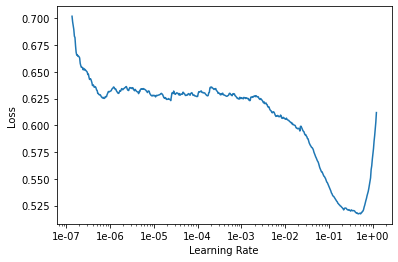

In [ ]:
learn_fn.recorder.plot(skip_end=25)

In [ ]:
learn_fn.fit_one_cycle(4, 4e-2,moms=(0.8,0.7),
                       callbacks=[SamplingCB2(learn_fn,num_samples=1000,objective_mols=obj_ref),
                                   SaveModelCallback(learn_fn, every='improvement',monitor='accuracy', name='bestmodel')])

epoch,train_loss,valid_loss,accuracy,error_rate,Valid,Unique,Novel,time
0,0.474551,0.449156,0.845897,0.154103,0.958000,0.958000,0.925000,02:22
1,0.467781,0.445632,0.847286,0.152714,0.953000,0.953000,0.919000,02:23
2,0.467089,0.442787,0.847816,0.152184,0.970000,0.968000,0.945000,02:19
3,0.465809,0.441456,0.848486,0.151514,0.961000,0.961000,0.931000,02:18


Sampling...
Sample of generated SMILES
['Cc1cc(C)nc(NC(=O)C(=O)c2cn(C(C)(C)C)c3ncccc23)n1', 'Cc1cccc(-c2cc(NC(=O)c3ccc(C(=O)Nc4cccc(C(=O)N5CCN(C)CC5)c4)cc3)cc(C(F)(F)F)c2)c1', 'CC(C)c1ccc2c(c1)CCC1C(C)(CN)CCCC21C', 'COc1ccc(N2CCN(C(=O)c3nc4ccccc4nc3Oc3ccc(O)c(C(=O)O)c3)CC2)cc1', 'COc1cc(C(=O)Nc2ccc(-c3ccc(-c4nc5cc(F)cc(F)c5[nH]4)cc3)cc2)cc(OC)c1OC']
['Cc1cc(C)nc(NC(=O)C(=O)c2cn(C(C)(C)C)c3ncccc23)n1', 'Cc1cccc(-c2cc(NC(=O)c3ccc(C(=O)Nc4cccc(C(=O)N5CCN(C)CC5)c4)cc3)cc(C(F)(F)F)c2)c1', 'CC(C)c1ccc2c(c1)CCC1C(C)(CN)CCCC21C', 'COc1ccc(N2CCN(C(=O)c3nc4ccccc4nc3Oc3ccc(O)c(C(=O)O)c3)CC2)cc1', 'COc1cc(C(=O)Nc2ccc(-c3ccc(-c4nc5cc(F)cc(F)c5[nH]4)cc3)cc2)cc(OC)c1OC']
Better model found at epoch 0 with accuracy value: 0.84589684009552.
Sampling...
Sample of generated SMILES
['CCN(CC)CCNC(=O)c1ccc(N/Cc2cn(-c3ccc(OC)cc3)nc2-c2ccc(F)cc2)cc1', 'Fc1ccc(Nc2ncnc3ccc(NC(=S)Nc4ccccc4Cl)cc23)cc1Cl', 'CCCCCCCCCCCCC(O)C1CCC(C(O)CCCCC(O)CCCCCCCCCC(O)CC2=CC(C)OC2=O)O1', 'NC(=O)c1ccc(-c2cnc3cnc(-c4cccnc4)cn23)cc

In [ ]:
learn_fn.save('fit1');

In [ ]:
learn_fn.freeze_to(-2)

In [ ]:
learn_fn.lr_find(num_it=600)

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.45E-07
Min loss divided by 10: 6.31E-04


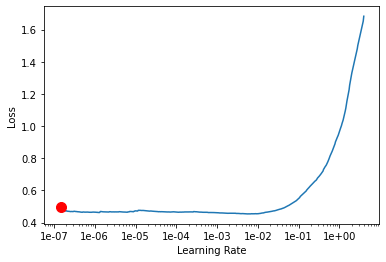

In [ ]:
learn_fn.recorder.plot(suggestion=True)

In [ ]:
learn_fn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3),moms=(0.8,0.7),
                        callbacks=[SamplingCB(learn_fn,num_samples=1000,objective_mols=obj_ref),
                                   SaveModelCallback(learn_fn, every='improvement', 
                                                     monitor='accuracy', name='bestmodel')])

epoch,train_loss,valid_loss,accuracy,error_rate,Valid,Unique,Novel,time
0,0.418731,0.396142,0.862717,0.137283,0.983000,0.952000,0.818000,02:33
1,0.380107,0.368816,0.871490,0.128510,0.986000,0.945000,0.735000,02:33
2,0.360735,0.360141,0.874757,0.125243,0.981000,0.955000,0.728000,02:33


Sampling...
Sample of generated SMILES
['CC(C)(C)c1ccc(Nc2ncnc3ccc(NC(=O)Nc4cccc(Cl)c4)cc23)cc1', 'COc1cc2c(Oc3ccc(NS(=O)(=O)c4cncn4C)cc3F)ccnc2cc1OCCCN1CCN(C)CC1', 'CC(C)(C)c1cc(NC(=O)Nc2ccc(-c3cc(NC(=O)c4ccnc(N5CCCC5)c4)cnc3-c3cccc(NCCN4CCOCC4)c3)cc2)no1', 'Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1-c1cnc(O[C@H](C)(C)C)c(N2CCOCC2)c1', 'CC(C)S(=O)(=O)Nc1ccc(CNC(=O)Nc2cc3[nH]nc(-c4ccnc(C(F)(F)F)c4)c3cn2)cc1']
['CC(C)(C)c1ccc(Nc2ncnc3ccc(NC(=O)Nc4cccc(Cl)c4)cc23)cc1', 'COc1cc2c(Oc3ccc(NS(=O)(=O)c4cncn4C)cc3F)ccnc2cc1OCCCN1CCN(C)CC1', 'CC(C)(C)c1cc(NC(=O)Nc2ccc(-c3cc(NC(=O)c4ccnc(N5CCCC5)c4)cnc3-c3cccc(NCCN4CCOCC4)c3)cc2)no1', 'CC(C)S(=O)(=O)Nc1ccc(CNC(=O)Nc2cc3[nH]nc(-c4ccnc(C(F)(F)F)c4)c3cn2)cc1', 'O=C(Nc1ccccc1)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5ccc(-c6ccccc6)cc5)CC4)c3n2)cc1']
Better model found at epoch 0 with accuracy value: 0.8627166748046875.
Sampling...
Sample of generated SMILES
['CC(C)Nc1nccc(-c2nc(C3CC3)[nH]c2-c2cccc(NS(=O)(=O)C(C)C)c2)n1', 'O=C(Nc1ccc(Oc2ccnc3[nH]ccc23)c(F)c1)c1n

In [ ]:
learn_fn.save('fit2')

In [ ]:
learn_fn.load('fit2');
learn_fn.unfreeze()

In [ ]:
learn_fn.lr_find(num_it=600)

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


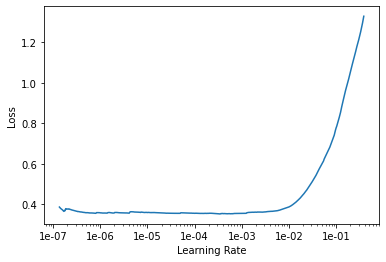

In [ ]:
learn_fn.recorder.plot()

In [ ]:
learn_fn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3),moms=(0.8,0.7),
                        callbacks=[SamplingCB2(learn_fn,num_samples=1000,objective_mols=obj_ref),
                                   SaveModelCallback(learn_fn, every='improvement', 
                                                     monitor='accuracy', name='bestmodel')])

epoch,train_loss,valid_loss,accuracy,error_rate,Valid,Unique,Novel,time
0,0.358883,0.358141,0.875621,0.124379,0.987000,0.935000,0.674000,02:40
1,0.349450,0.356334,0.876123,0.123877,0.986000,0.959000,0.688000,02:39


Sampling...
Sample of generated SMILES
['Cc1cc(-c2nc(-c3ccc(C(=O)NCC4CCCN4)cc3)c(-c3ccncn3)[nH]2)ccc1F', 'CN(C)C(=O)[C@H]1CCN(c2ccc(-c3ccc4[nH]c5nccc(-c6ccc(Oc7ccccc7C(F)(F)F)cc6)c5c4c3)cc2)CC1', 'COc1cc(-c2cnn(C)c2)ccc1Nc1ncc2ccnc(N3CCC4(COC4)C3)c2n1', 'Cn1cnc2cc(-c3ccc(N4CCOCC4)cc3)nc(NC3CC3)c2c1=O', 'CC(Nc1ncnc2c(C(N)=O)cccc12)c1cccc(NC(=O)c2cccc(C(F)(F)F)c2)c1']
['Cc1cc(-c2nc(-c3ccc(C(=O)NCC4CCCN4)cc3)c(-c3ccncn3)[nH]2)ccc1F', 'CN(C)C(=O)[C@H]1CCN(c2ccc(-c3ccc4[nH]c5nccc(-c6ccc(Oc7ccccc7C(F)(F)F)cc6)c5c4c3)cc2)CC1', 'COc1cc(-c2cnn(C)c2)ccc1Nc1ncc2ccnc(N3CCC4(COC4)C3)c2n1', 'Cn1cnc2cc(-c3ccc(N4CCOCC4)cc3)nc(NC3CC3)c2c1=O', 'CC(Nc1ncnc2c(C(N)=O)cccc12)c1cccc(NC(=O)c2cccc(C(F)(F)F)c2)c1']
Better model found at epoch 0 with accuracy value: 0.875621497631073.
Sampling...
Sample of generated SMILES
['Cc1cc(NC(=O)c2cccc(C(F)(F)F)c2)ccc1-c1cc(C2CCC(=O)NC2)ccc1F', 'COc1ccc(-c2ccc3c(N4CCOC[C@@H]4C)nc(N4CCCC4CO)nc3n2)cc1CO', 'CN(C)CCCn1cc(C2=C(n3ccc4ncccc43)C(=O)NC2=O)c2ccccc21', 'Nc1ncc(C2CC

In [ ]:
learn_fn.save('fit3')

In [ ]:
learn_fn.save_encoder('finetuned_encoder')

In [ ]:
learn_fn.export('finetuned_model')

In [ ]:
learn_fn.validate()

[0.3529547, tensor(0.8764), tensor(0.1236)]

# **Classifier**

In [ ]:
data_fn = load_data(COV,file='data_fn.pkl')
vocab = data_fn.vocab
learn_fn = load_learner(COV,file='finetuned_model.pkl')

**Databunch**

In [ ]:
tokenizer = Tokenizer(MolTokenizer,pre_rules=[],post_rules=[],special_cases=[PAD,BOS,EOS,UNK])
processors = [TokenizeProcessor(tokenizer=tokenizer, mark_fields=False,include_bos=False),
            NumericalizeProcessor(vocab=vocab)]

In [ ]:
src_cls = TextList.from_df(train_valid,path=COVCLS,cols='processed_smiles',processor=processors)
splt_cls = src_cls.split_from_df('is_valid')
data_cls = splt_cls.label_from_df(cols,classes=cols)

**Define a weighted sampler**

If your dataset is unbalanced, it might be a good idea to give lower weights to the majority class when creating batches. 

In [ ]:
def get_weights(data,n):
  '''Get sample weights based on distribution of classes. The minority class gets higher weights
  n: scaling factor'''
  labels = data.train_dl.dataset.y.items
  _, counts = np.unique(labels,return_counts=True)

  weights = tensor([n/counts[i] for i in labels]).float()
  weights = (weights if weights is not None else torch.DoubleTensor((1/counts)[labels]))
  return weights

weights = get_weights(data_cls,n=1) # Sample weights
weights,Counter(weights.numpy())
sampler = WeightedRandomSampler(weights=weights2,num_samples=len(weights2))

data_cls.train_dl = data_cls.train_dl.new(shuffle=False,sampler=sampler)

**Metrics and callbacks**

In [ ]:
metrics=[Recall(pos_label=1),Recall(pos_label=0),Precision(pos_label=1),MatthewsCorreff(),AUCPR()]
cb = [partial(CSVLogger,append=True)]


**Hyperparameters**

In [ ]:
config_cls = {'bidir': False,
 'emb_sz': 400,
 'embed_p': 0.02,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'n_hid': 512,
 'n_layers': 3,
 'output_p': 0.1,
 'pad_token': 1,
 'qrnn': False,
 'weight_p': 0.2}

**Training**

In [ ]:
learn = text_classifier_learner(data_cls, AWD_LSTM,pretrained=False,config=config_cls,drop_mult=0.1,
                                model_dir=Path('.'),
                                callback_fns=cb,
                                metrics=metrics).load_encoder('generative_model/finetuned_encoder');
learn.freeze()


In [ ]:
learn.lr_find(num_it=600)

epoch,train_loss,valid_loss,mcc_masked,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


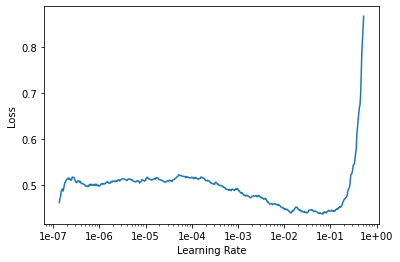

In [ ]:
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(5, slice(2e-3/(2.6**4),2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,mcc_masked,time
0,0.376505,0.156753,0.414273,01:48
1,0.341391,0.146253,0.464542,01:48
2,0.328708,0.141254,0.495106,01:48
3,0.299427,0.137588,0.509941,01:48
4,0.286381,0.137017,0.509926,01:47


Better model found at epoch 0 with mcc_masked value: 0.4142731726169586.
Better model found at epoch 1 with mcc_masked value: 0.4645422101020813.
Better model found at epoch 2 with mcc_masked value: 0.49510636925697327.
Better model found at epoch 3 with mcc_masked value: 0.5099408030509949.


In [ ]:
learn.save('fit1')

In [ ]:
learn.load('fit1');

In [ ]:
learn.freeze_to(-2)

In [ ]:
learn.lr_find(num_it=600)

epoch,train_loss,valid_loss,mcc_masked,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


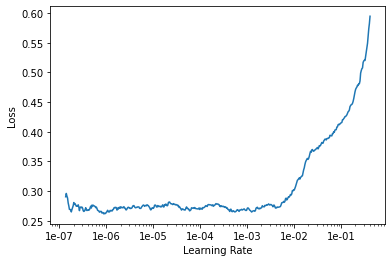

In [ ]:
learn.recorder.plot(skip_end=10)

In [ ]:
learn.fit_one_cycle(6, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,mcc_masked,time
0,0.285478,0.138816,0.519596,01:55
1,0.290936,0.138500,0.518232,01:51
2,0.279684,0.132332,0.536267,01:54
3,0.254055,0.130915,0.551414,01:55
4,0.237170,0.130105,0.556203,01:52
5,0.225277,0.130085,0.557957,01:52


Better model found at epoch 0 with mcc_masked value: 0.5195960998535156.
Better model found at epoch 2 with mcc_masked value: 0.536266565322876.
Better model found at epoch 3 with mcc_masked value: 0.5514141917228699.
Better model found at epoch 4 with mcc_masked value: 0.5562034249305725.
Better model found at epoch 5 with mcc_masked value: 0.5579574108123779.


In [ ]:
learn.save('fit2')

In [ ]:
learn.load('fit2');

In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,mcc_masked,time
0,0.234766,0.134132,0.551622,02:04
1,0.235918,0.130442,0.558590,02:01
2,0.214145,0.129669,0.577453,02:00
3,0.197284,0.129269,0.578517,02:00


Better model found at epoch 0 with mcc_masked value: 0.5516223311424255.
Better model found at epoch 1 with mcc_masked value: 0.5585899949073792.
Better model found at epoch 2 with mcc_masked value: 0.5774529576301575.
Better model found at epoch 3 with mcc_masked value: 0.5785174369812012.


In [ ]:
learn.save('fit3')

In [ ]:
learn.load('fit3');
learn.unfreeze();

In [ ]:
learn.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,mcc_masked,time
0,0.204924,0.132500,0.562784,02:10
1,0.215570,0.133978,0.565579,02:11
2,0.195199,0.132554,0.575981,02:10
3,0.162561,0.132709,0.571924,02:13


Better model found at epoch 0 with mcc_masked value: 0.5627838373184204.
Better model found at epoch 1 with mcc_masked value: 0.5655791163444519.
Better model found at epoch 2 with mcc_masked value: 0.5759810209274292.


In [ ]:
learn.save('fit4')

In [ ]:
#learn.load('fit4');
learn.validate()

[0.12907319, tensor(0.0603)]

In [ ]:
learn.fit_one_cycle(6, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,mcc_masked,time
0,0.164547,0.135387,0.576994,02:15
1,0.195788,0.140671,0.569276,02:16
2,0.187184,0.139009,0.571644,02:16
3,0.176278,0.139293,0.582603,02:18
4,0.133000,0.141072,0.582924,02:15
5,0.132051,0.141394,0.584821,02:16


Better model found at epoch 0 with mcc_masked value: 0.5769940614700317.
Better model found at epoch 3 with mcc_masked value: 0.5826025009155273.
Better model found at epoch 4 with mcc_masked value: 0.5829238295555115.
Better model found at epoch 5 with mcc_masked value: 0.5848205089569092.


In [ ]:
learn.save('fit5')